In [2]:
#installations
pip install numpy pandas opencv-python-headless tensorflow matplotlib scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np
import os
from tensorflow.keras import callbacks, regularizers

In [3]:
# Configuration
IMAGE_SIZE = (400, 300)
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 5
train_dir = '/kaggle/input/Project-1/Train_Data'
test_dir = '/kaggle/input/Project-1/Test_Data'

# Load the dataset
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)

val_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2516 files belonging to 5 classes.
Using 2013 files for training.
Found 2516 files belonging to 5 classes.
Using 503 files for validation.


In [4]:
# 2. Class Weight Calculation
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))

In [5]:
# 3. Augmentation Function
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),    # Flip horizontally and vertically
    layers.RandomRotation(0.2),                      # Random rotation
    layers.RandomZoom(0.2),                          # Random zoom
    layers.RandomContrast(0.2),                      # Random contrast adjustment
    layers.RandomTranslation(0.1, 0.1),              # Random translation (shift) in both directions
    layers.GaussianNoise(0.1)                        # Add Gaussian noise
])


In [6]:
# 4. Apply data augmentation
def augment(images, labels):
    return data_augmentation(images), labels

augmented_train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
# 5. Prefetch for performance optimization
train_ds = augmented_train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Build ResNet-based model for transfer learning
base_model = keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Cosine Decay Learning Rate Schedule
initial_learning_rate = 1e-5  # Reduced starting learning rate
final_learning_rate = 1e-6  # Minimum learning rate
epochs = EPOCHS

def cosine_decay(epoch):
    cosine_decay_value = 0.5 * (1 + np.cos(np.pi * epoch / epochs))
    decayed_learning_rate = (initial_learning_rate - final_learning_rate) * cosine_decay_value + final_learning_rate
    return decayed_learning_rate

# Learning Rate Scheduler Callback
lr_scheduler = callbacks.LearningRateScheduler(cosine_decay)

# Build the model with Dropout and L2 regularization
def build_improved_model():
    base_model.trainable = False  # Freeze the base model initially

    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = data_augmentation(inputs)  # Apply data augmentation
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Layers with Dropout and L2 Regularization (Reduced complexity)
    x = layers.Dense(512, activation='silu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)  # Moderate dropout rate
    
    x = layers.Dense(256, activation='silu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the improved model
model = build_improved_model()

# Unfreeze the last 100 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-100]:  # Freeze layers before the last 100
    layer.trainable = False

# Recompile after unfreezing
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,  # Stop if val_loss doesn't improve after 10 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[lr_scheduler],  # Include early stopping
    verbose=1
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1810 - loss: 1.8712 - val_accuracy: 0.1690 - val_loss: 1.7782 - learning_rate: 1.0000e-05
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2115 - loss: 1.8022 - val_accuracy: 0.1590 - val_loss: 1.7610 - learning_rate: 9.9911e-06
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2330 - loss: 1.7063 - val_accuracy: 0.2107 - val_loss: 1.7298 - learning_rate: 9.9645e-06
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2669 - loss: 1.7044 - val_accuracy: 0.2386 - val_loss: 1.7135 - learning_rate: 9.9203e-06
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2589 - loss: 1.6974 - val_accuracy: 0.2744 - val_loss: 1.6938 - learning_rate: 9.8586e-06
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2700 - loss: 1.6824 - val_accuracy: 0.2644 - val_loss: 1.6803 - learning_rate: 9.7798e-06
Epoch 7/50
32/32 ━━━━━━━━

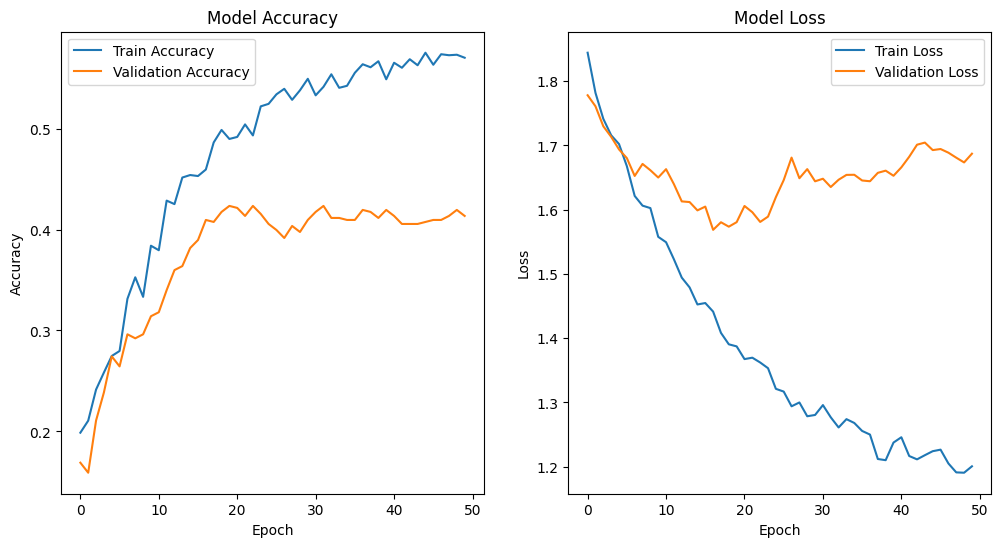

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.show()


In [10]:
# 9. Prediction on Test Data
test_ds = image_dataset_from_directory(
    test_dir,
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False  # Do not shuffle so predictions match the order in test data
)

predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

Found 478 files.
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step


In [11]:
# 10. Create submission file
image_ids = [int(os.path.basename(file).split(".")[0]) for file in test_ds.file_paths]
submission = np.column_stack((image_ids, predicted_classes + 1))  # Map 0-index to 1-5

# Save submission as CSV
np.savetxt('submission.csv', submission, fmt='%d,%d', header='ID,Predictions', comments='', delimiter=',')